In [55]:
# pip install pydup
# pip install librosa

In [56]:
import wave
from pydub import AudioSegment as auds
import pandas as pd
import numpy as np
import os, fnmatch
from matplotlib import pyplot as plt
import scipy.io.wavfile as wf
from scipy.integrate import simps
from scipy.fftpack import dct
# import librosa
import numpy as np

In [57]:
# Sciezka
path = 'C:/Users/karol/Desktop/AGH/MAGISTERKA/SEMESTR 3/Eksploracja i Glosowa/Nagrania'

# Wyciaganie nazw plikow ze sciezki
list_of_files = os.listdir(path)
pattern = "*.txt"
list_of_names = []
for entry in list_of_files:
    if fnmatch.fnmatch(entry, pattern):
            list_of_names.append(entry[:-4])

# Utworzenie list plikow wav i txt
files_wav_list = []
files_txt_list = []
for filename in list_of_names:
    files_wav_list.append(filename + '.wav')
    files_txt_list.append(filename + '.txt')
    
print('Obecne pliki:')

for i in range(len(list_of_names)):
    print(files_txt_list[i], files_wav_list[i])
print('liczba plikow: ', len(list_of_names))

Obecne pliki:
289516_25_K_01_2.txt 289516_25_K_01_2.wav
289516_25_K_10_3.txt 289516_25_K_10_3.wav
289516_25_K_16_4.txt 289516_25_K_16_4.wav
289516_25_K_22_1.txt 289516_25_K_22_1.wav
289540_23_K_13_2.txt 289540_23_K_13_2.wav
289540_23_K_18_3.txt 289540_23_K_18_3.wav
289540_23_K_22_4.txt 289540_23_K_22_4.wav
289540_23_K_9_1.txt 289540_23_K_9_1.wav
289550_23_K_18_2.txt 289550_23_K_18_2.wav
289550_23_K_23_3.txt 289550_23_K_23_3.wav
289550_23_K_23_4.txt 289550_23_K_23_4.wav
289550_23_K_9_1.txt 289550_23_K_9_1.wav
289556_24_K_11_1.txt 289556_24_K_11_1.wav
289556_24_K_15_2.txt 289556_24_K_15_2.wav
289556_24_K_19_3.txt 289556_24_K_19_3.wav
289556_24_K_23_4.txt 289556_24_K_23_4.wav
404907_23_K_11_1.txt 404907_23_K_11_1.wav
404907_23_K_14_2.txt 404907_23_K_14_2.wav
404907_23_K_16_3.txt 404907_23_K_16_3.wav
404907_23_K_20_4.txt 404907_23_K_20_4.wav
liczba plikow:  20


In [58]:
# Wczytywanie plikow z etykietami
textfile = pd.read_csv(path + '/' + file_txt, sep = '\t', header = None)

# Poprawianie etykiet
labels = []
for i in range(0,100):
    labels.append(str(textfile[2][i]))
    if labels[i] == 'nan':
        labels[i] = 'NA'
    labels[i] = labels[i].upper()      # Jesli sa male litery to zamienia na duze
#     print(labels[i])

289516_25_K_10_3_OTWORZ.wav
(123, 12)
Długość sygnału: 55345
Czas w sekundach: 1.2549886621315194
Liczba ramek: 123


Text(0, 0.5, 'Współczynniki MFCC')

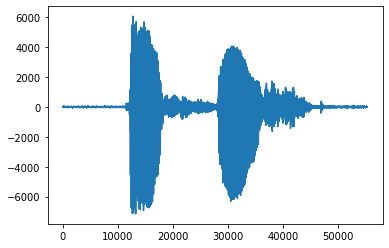

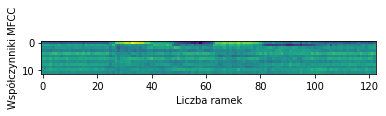

In [120]:
# # Wybor pliku
nr = 1
filename = list_of_names[nr]
# file_wav = files_wav_list[nr]
# file_txt = files_txt_list[nr]
# print(file_wav, file_txt)

nr_word = 0
path_word = path + "/" + labels[nr_word]
print(filename + '_' + labels[nr_word] + '.wav')

# korzystałam z: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

# Wczytanie słowa
sample_rate, signal = wf.read(path_word + '/' + filename + '_' + labels[nr_word] + '.wav')

plt.figure()
plt.plot(signal)

# Preemfaza
pre_emphasis = 0.97 # parametr
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

# Formowanie ramek
frame_size = 0.025
frame_stride = 0.01 # bo sygnał jest w ms
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate # zamiana z sekund na próbki
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Sprawdzanie czy jest chociaż jedna ramka

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Upewnianie się, że wszystkie ramki mają równą liczbę próbek bez obcinania jakichkolwiek próbek z oryginalnego sygnału

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

# Okienkowanie
frames = frames * np.hamming(frame_length) # Hamming najczęściej stosowany w rozpoznaniu mowy

# FFT i Power Spectrum // powstaje widmo liniowe
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

# Bank filtrów // powstaje widmo melowe
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Konwersja Hz do Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Równo rozmieszczona skala Mel
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Konwersja Mel do Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # lewe
    f_m = int(bin[m])             # centrum
    f_m_plus = int(bin[m + 1])    # prawe

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Stabilność numeryczna

# Logarytmowanie
filter_banks = 20 * np.log10(filter_banks)  # dB

# Współczynniki cepstralne częstotliwości mel -- Mel-frequency Cepstral Coefficients (MFCCs)
# DCT
num_ceps =12 # liczba współczynników - między 2 a 13
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]
print(mfcc.shape) # (l.ramek, l.współczynników)
print('Długość sygnału:', len(signal))
print('Czas w sekundach:', len(signal)/sample_rate)
print('Liczba ramek:', num_frames)

plt.figure()
plt.imshow(mfcc.T)
plt.xlabel("Liczba ramek")
plt.ylabel("Współczynniki MFCC")